In [44]:
import numpy as np
import pandas as pd

# Data Import and Exploration

In [45]:
product_quality_log = pd.read_csv('task3_dataset/product_quality_log.csv')
product_quality_log = product_quality_log.drop(product_quality_log.columns[[0]], axis=1)
print(product_quality_log.head(7))

      machine_id product_id quality
0  Printer F0815   P3.2.500      OK
1  Printer F0815   P3.2.501      OK
2  Printer F0815   P3.2.502      OK
3  Printer F0815   P3.2.503      OK
4  Printer F0815   P3.2.504      OK
5  Printer F0815   P3.2.505      OK
6  Printer F0815   P3.2.506      OK


In [46]:
production_log = pd.read_csv('task3_dataset/production_log.csv')
production_log = production_log.drop(production_log.columns[[0]], axis=1)
print(production_log.head(7))

             timestamp product_id
0  2021-05-17_08-12-48   P3.2.500
1  2021-05-17_08-12-51   P3.2.501
2  2021-05-17_08-12-54   P3.2.502
3  2021-05-17_08-12-57   P3.2.503
4  2021-05-17_08-13-00   P3.2.504
5  2021-05-17_08-13-03   P3.2.505
6  2021-05-17_08-13-06   P3.2.506


In [47]:
complete_log = pd.merge(production_log, product_quality_log, on="product_id")
complete_log = complete_log.set_index('timestamp')
print(complete_log.head(7))

                    product_id     machine_id quality
timestamp                                            
2021-05-17_08-12-48   P3.2.500  Printer F0815      OK
2021-05-17_08-12-51   P3.2.501  Printer F0815      OK
2021-05-17_08-12-54   P3.2.502  Printer F0815      OK
2021-05-17_08-12-57   P3.2.503  Printer F0815      OK
2021-05-17_08-13-00   P3.2.504  Printer F0815      OK
2021-05-17_08-13-03   P3.2.505  Printer F0815      OK
2021-05-17_08-13-06   P3.2.506  Printer F0815      OK


In [48]:
import os

path = 'task3_dataset/vibrationdata'
folder = os.fsencode(path)

vibrationdata = pd.DataFrame(columns=["S1_mean", "S2_mean", 
                                      "S1_SD", "S2_SD", 
                                      "timestamp", "quality"])

#looping through all files in the directory
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    file = open(path+"/"+filename)
    
    #loading the file data into a temporary numpy array
    temp_array = np.loadtxt(file,delimiter='\t').astype(float)
    
    
    #Spectral Transformation
    #t= np.linspace(0,3,20480)
    tr = np.fft.fft(temp_array) # complex spectrum
    #tr_abs = np.abs(tr) # amplitude spectrum
    #f=np.fft.fftfreq(t.shape[-1])
    
    
    #calculating data properties
    mean = tr.mean(0)
    sd = np.std(tr,0)
    
    #Appending the features of each file to a dataframe
    data_dictionary = {"S1_mean": mean[0].real, "S2_mean": mean[1].real,
                       "S1_SD": sd[0], "S2_SD": sd[1], 
                       "timestamp": filename, "quality": complete_log.loc[filename]['quality']
                      }
    vibrationdata = vibrationdata.append(data_dictionary, ignore_index=True)
    

print(vibrationdata.head(5))


    S1_mean   S2_mean     S1_SD     S2_SD            timestamp quality
0 -0.236402 -0.000018  0.218936  0.211095  2021-05-17_09-35-33     nOK
1 -0.232481  0.000092  0.132825  0.108592  2021-05-17_08-45-27      OK
2 -0.233793 -0.000221  0.132473  0.107181  2021-05-17_08-18-48      OK
3 -0.234725 -0.000202  0.132637  0.104239  2021-05-17_08-17-00      OK
4 -0.234847  0.000125  0.129376  0.108305  2021-05-17_08-42-30      OK


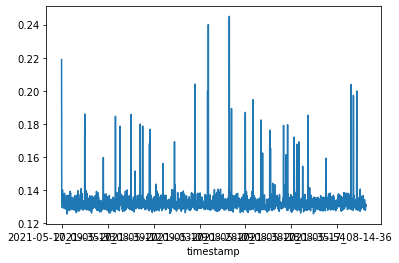

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt

vibrationdata.plot(x="timestamp", y="S1_SD", legend=None, y_label=" ")
plt.show()

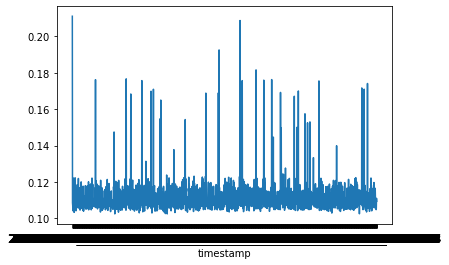

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt

vibrationdata.plot(x="timestamp", y="S2_SD", legend=None)
plt.show()

In [54]:
x1 = vibrationdata["S1_SD"]
x2 = vibrationdata["S2_SD"]
y = vibrationdata["quality"]

#test train split
x1_train = x1[0:994]
x2_train = x1[0:994]

(1656,) (1656,) (1656,)


In [ ]:
from sklearn.linear_model import LogisticRegression

